<a href="https://colab.research.google.com/github/csklaver/ML_Kiva_Crowdfunding/blob/main/Final_draft_4_28.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b>

<p>
<center>
<font size="5">
Machine Learning I (DATS 6202), Spring 2020
</font>
</center>
</p>

<p>
<center>
<font size="4">
Kiva Crowdfunding: A Machine Learning Analysis​
</font>
</center>
</p>

<p>
<center>
<font size="3">
Data Science, Columbian College of Arts & Sciences, George Washington University
</font>
</center>
</p>

<p>
<center>
<font size="3">
Authors: Andrea Piolini, Caroline Sklaver, Anwesha Tomar, Sandra Valdés Salas​
</font>
</center>
</p>

</b>

# 1. Introduction

"Kiva.org is an online crowdfunding platform to extend financial services to poor and financially excluded people around the world". Kiva has provided data on their world-wide financial loans over the past two years on kaggle.com. Our aim is to apply machine learning methods to gain insight into how Kiva determines the amount (USD) and repayment interval type (monthly, bullet, or irregular) of each loan. Throughout this project, we hope to highlight the most important features in determining how Kiva administers loans. Given the number of data points in the original dataset, we have decided to focus on Latin American countries out of personal interest and to narrow our focus. Kiva provides features such as number of lenders, borrower's gender(s), loan use activity, and more. Our goals in this project are to build models to predict the loan amount (regression) and the repayment interval type (classification).  This information can inform both lenders and borrowers in the Kiva crowdfunding process. To achieve these goals we will preprocess the data (merging, cleaning, handling identifiers and missing values, etc.), perform exploratory data analyses, split the data into training, validation, and testing sets, chose a variety of models for both regression and classification problems, and fine-tune the hyperparameters of those models. In all, we hope to gain experience by applying our knowledge from our Machine Learning I course to real-world data.


# 2. Loading and preparing the data

## 2.1 Notebook Configuration

In [ ]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Set working directory
%cd /content/drive

[Errno 2] No such file or directory: '/content/drive'
/content


In [ ]:
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

## 2.2 Import all datasets

In [ ]:
import pandas as pd

# load loans dataset
df_raw_loans = pd.read_csv("kiva_loans.csv", header=0) #main dataset

# load MPI dataset
df_mpi_new = pd.read_csv("MPI.csv", header=0)

FileNotFoundError: ignored

## 2.3 Merge loans dataset and MPI dataset

In [ ]:
# Print first lines of df_mpi_new
df_mpi_new.head()

,HDI Rank,Country,2007,Unnamed: 3,2008,Unnamed: 5,2009,Unnamed: 7,2010,Unnamed: 9,2011,Unnamed: 11,2012,Unnamed: 13,2013,Unnamed: 15,2014,Unnamed: 17,2015,Unnamed: 19,2016,Unnamed: 21,2017,Unnamed: 23,2018,Unnamed: 25,2007-2018,Unnamed: 27
0,Multidimensional poverty index (MPI)\nnull\nDi...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,170,Afghanistan,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,0.272,"a,b",..,NaN,..,NaN,0.272,"a,b"
2,69,Albania,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,0.003,a,0.003,a
3,82,Algeria,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,0.008,a,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,0.008,a
4,149,Angola,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,0.282,a,..,NaN,..,NaN,0.282,a


In [ ]:
# create new dataframe with just country and MPI
df_mpi_new_subset = pd.DataFrame()
df_mpi_new_subset['country'] = df_mpi_new['Country']
df_mpi_new_subset['MPI'] = df_mpi_new['2007-2018']

#Print head of df_mpi_new_subset
df_mpi_new_subset.head()

,country,MPI
0,NaN,NaN
1,Afghanistan,0.272
2,Albania,0.003
3,Algeria,0.008
4,Angola,0.282


In [ ]:
#Drop NaNs from MPI subset
df_mpi_new_subset.dropna(inplace=True)

In [ ]:
# get rid of whitespace in MPI subset
df_mpi_new_subset['country'] = df_mpi_new_subset['country'].str.lstrip()

In [ ]:
# Merge df_raw_loans and df_mpi_new_subset
df_raw_final = pd.merge(df_raw_loans,df_mpi_new_subset, on='country',how='left')

In [ ]:
# Print the dimension of df_raw_final
pd.DataFrame([[df_raw_final.shape[0], df_raw_final.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,671205,21


In [ ]:
#Convert MPI to numeric
df_raw_final['MPI'] = df_raw_final['MPI'].apply(pd.to_numeric, errors='coerce')

## 2.4 Group activities

In [ ]:
# Define function to group items
def group_items(item, group):
    for key, value in group.items():
        if item in value:
            return key

In [ ]:
# Create a dictionary of activities
activities_dict = {'healthcare' : ["Adult Care", "Child Care", "Dental", "Health", "Medical Clinic", 
                                   "Natural Medicines", "Personal Care Products",
                                   "Personal Medical Expenses", "Pharmacy", "Veterinary Sales"],
                   'agriculture_and_livestock' : ["Agriculture", "Animal Sales", "Aquaculture", 
                                                  "Beekeeping", "Cattle", "Farm Supplies",
                                                  "Farming", "Fishing", "Livestock", "Milk Sales", "Pigs", "Poultry"], 
                   'maintenance' : ["Air Conditioning", "Auto Repair", "Bicycle Repair", "Electronics Repair", 
                                     "Motorcycle Repair", "Phone Repair", "Vehicle Repairs"],
                    'arts_and_crafts' : ["Arts", "Crafts", "Embroidery", "Patchwork", "Sewing", "Textiles", "Weaving"],
                    'food_and_beverages' : ["Bakery", "Balut-Making", "Beverages", "Cereals", "Cheese Making", "Cobbler", 
                                            "Dairy", "Food", "Food Production/Sales", "Food Market", "Fruits & Vegetables"],
                    'construction_materials' : ["Bricks", "Cement", "Carpentry", "Construction", "Construction Supplies", 
                                                "Electrician"],
                    'business' : ["Bicycle Sales", "Blacksmith", "Bookbiding", "Bookstore", "Butcher Shop", "Cafe", 
                                  "Catering", "Charcoal Sales", "Clothing Sales", "Cosmetic Sales", "Decoration Sales", 
                                  "Electronics Sales", "Fish Selling", "Florist", "Food Market", "Food Stall", 
                                  "Furniture Making", "General Store", "Grocery Store", "Home Products Sales","Hotel", 
                                  "Internet Cafe", "Land Rental", "Landscaping/Gardening", "Laundry", "Liquor Store / Off-License", 
                                  "Machine Shop", "Machinery Rental", "Manufacturing", "Metal Shop", "Paper Sales", 
                                  "Personal Products Sales", "Phone Use Sales", "Plastics Sales", "Quarrying", "Restaurant", "Retail", "Shoe Sales", "Souvenir Sales", 
                                  "Sporting Good Sales", "Tailoring", "Taxi", "Rickshaw", "Timber Sales", "Traveling Sales",
                                  "Upholstery", "Wholesale", "Barber Shop", "Beauty Salon", "Call Center"], 
                   'entertainment' : ["Celebrations", "Entertainment", "Film", "Games", "Movie Tapes & DVDs", 
                                      "Music Discs & Tapes", "Musical Instruments", "Musical Performance", "Party Supplies",
                                      "Photography", "Pub", "Wedding Expenses"],
                   'services' : ["Cleaning Services", "Secretarial Services", "Services", "Tourism", "Transportation", 
                                 "Utilities", "Waste Management", "Water Distribution", "Well digging"],
                   'supplies' : ["Cloth & Dressmaking Supplies", "Clothing", "Goods Distribution", "Office Supplies", 
                                 "Used Clothing", "Used Shoes"],
                   'technology_and_IT' : ["Communications", "Computer", "Computers", "Hardware", "Mobile Phones", 
                                          "Mobile Transactions", "Phone Accessories", "Technology", "Electrical Goods"],
                   'miscellaneous' : ["Consumer Goods", "Event Planning", "Flowers", "Funerals", "Home Appliances", 
                                       "Jewelry", "Knitting", "Motorcycle Transport", "Perfumes", "Personal Expenses", 
                                       "Personal Housing Expenses", "Printing", "Property", "Recycled Materials", 
                                      "Recycling", "Religious Articles", "Spare Parts", "Vehicle"],
                   'education' : ["Education provider", "Higher education costs", "Primary/secondary school costs"],
                    'energy' : ["Energy", "Fuel/Firewood", "Home Energy", "Renewable Energy Products"]}

In [ ]:
# Call group_items on df_raw_final
df_raw_final['activities'] = df_raw_final['activity'].apply(lambda x: group_items(x, activities_dict))


## 2.5 Group countries 

In [ ]:
# Create a dictionary of regions
areas = {'South_East_Asia' : ['Philippines', 'Indonesia', 'Timor-Leste'],
         'Eastern_Asia' : ['China', 'Cambodia', 'Vietnam',"Lao People's Democratic Republic", 'Thailand'],
         'Eastern_Africa' : ['Kenya', 'Uganda', 'Mali', 'Rwanda', 'Tanzania','Madagascar', 'Mozambique','Egypt', 'Somalia'],
         'Western_Africa' : ['Togo', 'Sierra Leone', 'Ghana', 'Liberia', 'Senegal', 'Burkina Faso', 'Cameroon',
                             'Mauritania', "Cote D'Ivoire", 'Benin', 'Nigeria'],
         'Southern_Africa' : ['Zimbabwe', 'Malawi', 'Zambia', 'Lesotho', 'South Africa', 'Namibia'],
         'Central_Africa' : ['The Democratic Republic of the Congo', 'Burundi', 'Zambia', 'South Sudan', 'Congo'],
         'Central_America' : ['El Salvador', 'Nicaragua', 'Honduras', 'Haiti', 'Costa Rica', 'Dominican Republic',
                             'Panama', 'Belize', 'Puerto Rico', 'Saint Vincent and the Grenadines'], 
         'South_Asia' : ['Pakistan', 'India', 'Myanmar (Burma)', 'Nepal', 'Bhutan'],
         'South_America' : ['Peru', 'Colombia', 'Ecuador', 'Paraguay', 'Brazil', 'Suriname', 'Bolivia', 'Chile'],
         'Central_Asia' : ['Tajikistan', 'Kyrgyzstan', 'Mongolia'],
         'Middle_East' : ['Lebanon', 'Palestine', 'Jordan', 'Yemen', 'Turkey', 'Iraq', 'Israel', 'Afghanistan'],
         'Pacific_Islands' : ['Samoa', 'Solomon Islands', 'Vanuatu', 'Guam'],
         'North_America' : ['United States', 'Mexico', 'Virgin Islands'],
         'Eastern Europe' : ['Armenia', 'Georgia', 'Albania', 'Azerbaijan', 'Kosovo', 'Ukraine', 'Moldova']}

In [ ]:
# Call group_items on df_raw_final
df_raw_final['grouped_countries'] = df_raw_final['country'].apply(lambda x: group_items(x, areas))

In [ ]:
areas = df_raw_final.groupby('grouped_countries').size()
areas

grouped_countries
Central_Africa       4241
Central_America     64290
Central_Asia        26318
Eastern Europe      17649
Eastern_Africa     124037
Eastern_Asia        47479
Middle_East         26327
North_America       11836
Pacific_Islands      7955
South_America       78975
South_Asia          40683
South_East_Asia    169345
Southern_Africa      6946
Western_Africa      37814
dtype: int64

## 2.6 Split Borrower Gender

In [ ]:
# Define function to split borrower_genders
def split_borrowers_gender(data):
    missing=0
    list_m=[]
    list_f=[]
    for gender in data:
        count_m=0
        count_f=0
        if type(gender) == float:
            missing = missing+1
        else:
            gender = gender.replace(",", " ")
            mainlist = gender.split(" ")
            for lg in mainlist:
                if lg=="female":
                    count_f=count_f+1
                elif lg=="male":
                    count_m=count_m+1
        list_m.append(count_m)
        list_f.append(count_f)
    return list_m,list_f,missing

In [ ]:
# Extract borrowers data
borrowers_gender_data = df_raw_final['borrower_genders'][:]

# Call split_borrowers_gender  
m1,f1,miss = split_borrowers_gender(borrowers_gender_data)

# Create new columns on df_raw_final
df_raw_final['male_borrowers']=m1
df_raw_final['female_borrowers']=f1

## 2.7 Drop unnecessary columns

In [ ]:
# Create function to drop unnecessary columns
def drop_values(df, list_variables):
    for variable in list_variables:
        df.drop([variable], axis=1, inplace=True)
    return df

In [ ]:
# Define variables to drop
list_to_drop = ['partner_id', 'tags','use','posted_time','disbursed_time','funded_time',
                'date','country_code','funded_amount','activity','currency',
                'borrower_genders','sector']

In [ ]:
# Call drop_values on df_raw_final
df_raw_final = drop_values(df_raw_final, list_to_drop)

## 2.8 Choose Latin American countries

In [ ]:
# Choose only coutries of Latin American region --> includes subregions: Central America and South America
df_latam = df_raw_final.loc[(df_raw_final['grouped_countries']=='South_America') | 
                 (df_raw_final['grouped_countries']=='Central_America')]

In [ ]:
df_latam['country'].value_counts()

El Salvador                         39875
Peru                                22233
Colombia                            21995
Ecuador                             13521
Paraguay                            11903
Nicaragua                           11781
Bolivia                              8806
Honduras                             6557
Haiti                                3618
Costa Rica                           1561
Dominican Republic                    496
Brazil                                284
Suriname                              223
Panama                                193
Belize                                125
Puerto Rico                            68
Saint Vincent and the Grenadines       16
Chile                                  10
Name: country, dtype: int64

In [ ]:
#Drop the column "grouped_countries"
df_latam.drop(['grouped_countries'], axis=1, inplace=True)

## 2.9 Check data frame

In [ ]:
# Define function to check columns of data frame
def check_columns(df):
  """
  Parameters
  ----------
  df : dataframe
    
  Returns
  ----------
  The dataframe of variables with total unique values and dtype of variable
  """

  # Get the dataframe of variables with their total unique values and dtype
  df_values = pd.DataFrame([[var, df[var].nunique(),df[var].dtype] for var in df.columns],
             columns=['var','values','type'])

  # Sort df_values in accending order of the total number of values
  df_values = df_values.sort_values(by='values', ascending=False).reset_index(drop=True)
    
  return df_values

In [ ]:
# Call check_columns on df_raw_final
check_columns(df_latam)

,var,values,type
0,id,143265,int64
1,region,1616,object
2,loan_amount,375,float64
3,lender_count,331,int64
4,term_in_months,140,float64
5,female_borrowers,33,int64
6,country,18,object
7,activities,14,object
8,male_borrowers,14,int64
9,MPI,12,float64


In [ ]:
# Print the dimension of df_raw_final
pd.DataFrame([[df_latam.shape[0], df_latam.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,143265,11


In [ ]:
df_latam.head()

,id,loan_amount,country,region,term_in_months,lender_count,repayment_interval,MPI,activities,male_borrowers,female_borrowers
48,653359,600.0,Nicaragua,Leon,14.0,16,monthly,0.074,business,0,1
49,653418,450.0,El Salvador,NaN,14.0,18,monthly,0.032,business,1,0
53,653432,550.0,Peru,Ica,14.0,20,monthly,0.053,miscellaneous,1,0
69,653410,1075.0,Peru,Ica,17.0,41,monthly,0.053,services,1,0
80,653430,1000.0,Honduras,"Nueva Frontera, Santa Barbara.",20.0,34,monthly,0.090,business,0,1


## 2.10 Exploratory Data Analysis

Text(0.5, 1.0, 'Distribution of Countries')

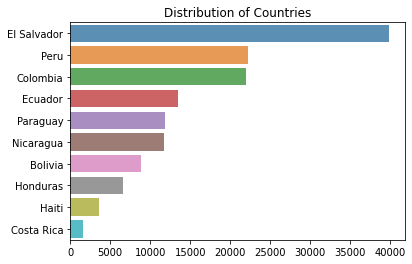

In [ ]:
# countries
import seaborn as sns
import matplotlib.pyplot as plt

top_countries = df_latam["country"].value_counts()[:10]
top_countries.sort_values(ascending=False, inplace=True)

current_palette = sns.color_palette()

sns.barplot(top_countries.values, top_countries.index, alpha=0.8)
plt.title("Distribution of Countries")


Text(0, 0.5, 'Frequency')

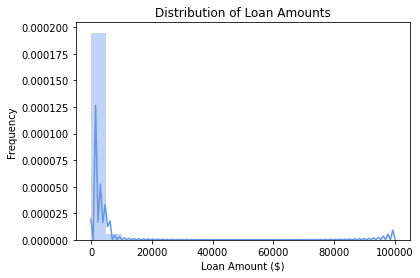

In [ ]:
# LOAN AMOUNT
colors = 'cornflowerblue'
sns.distplot(df_latam['loan_amount'], bins=20, color=colors)
plt.title('Distribution of Loan Amounts')
plt.xlabel('Loan Amount ($)')
plt.ylabel('Frequency')

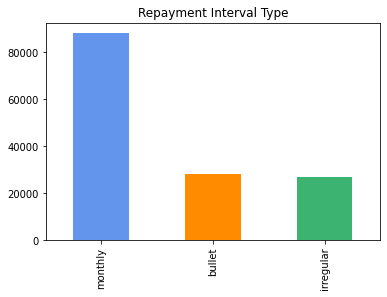

In [ ]:
# REPAYMENT INTERVAL

colors_3 = ['cornflowerblue','darkorange', 'mediumseagreen']
rep_int = df_latam['repayment_interval'].value_counts()
rep_int.plot.bar(title='Repayment Interval Type', color=colors_3)

Text(0.5, 1.0, 'Distribution of Activities')

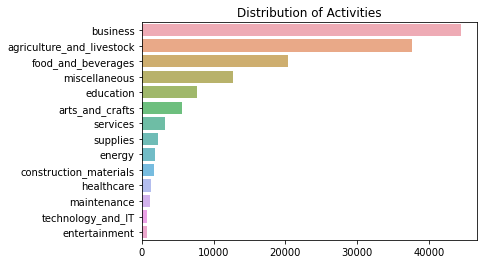

In [ ]:
# ACTIVITES

activities_bar = df_latam["activities"].value_counts()
activities_bar.sort_values(ascending=False, inplace=True)

sns.barplot(activities_bar.values, activities_bar.index, alpha=0.8)
plt.title("Distribution of Activities")

Text(0.5, 1.0, 'Distribution of Loan Term (Months)')

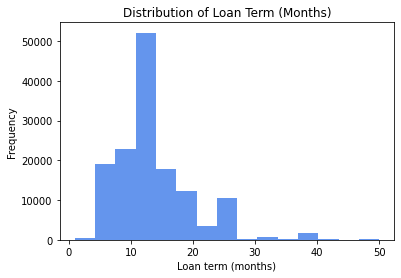

In [ ]:
# TERM IN MONTHS

colors = 'cornflowerblue'
funded_amount_hist = plt.hist(df_latam['term_in_months'], bins=15, range=[1,50], color=colors)

plt.ylabel('Frequency')
plt.xlabel('Loan term (months)')
plt.title("Distribution of Loan Term (Months)")

Text(0.5, 1.0, 'Distribution of Lender Count')

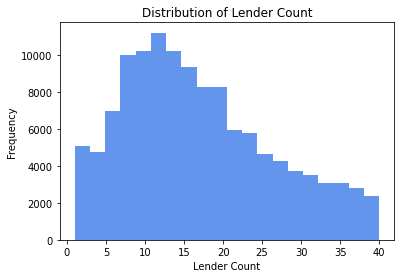

In [ ]:
#  LENDER COUNT (# of lenders contributing to the loan)

funded_amount_hist = plt.hist(df_latam['lender_count'], bins=20, range=[1,40], color=colors)
plt.ylabel('Frequency')
plt.xlabel('Lender Count')
plt.title("Distribution of Lender Count")

Text(0.5, 1.0, 'Distribution of MPI')

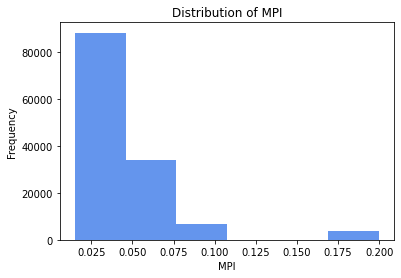

In [ ]:
# MPI

funded_amount_hist = plt.hist(df_latam['MPI'], bins=6, color=colors)
plt.ylabel('Frequency')
plt.xlabel('MPI')
plt.title("Distribution of MPI")

Text(0.5, 1.0, 'Borrower Genders')

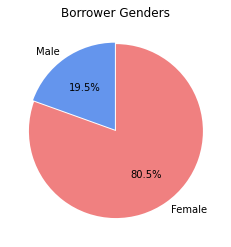

In [ ]:
# BORROWER GENDER

male_borrowers = sum(df_latam['male_borrowers'])
female_borrowers=sum(df_latam['female_borrowers'])

labels='Male','Female'
sizes=[male_borrowers,female_borrowers]
colors_2=['cornflowerblue','lightcoral']
plt.pie(sizes, explode=(0.02,0), labels=labels,colors=colors_2, startangle=90, autopct='%1.1f%%')
plt.title('Borrower Genders')


## 2.11 Create copy of Latam dataframe

In [ ]:
df_preprocessed = df_latam.copy(deep=True)

# 3. Data Preprocessing

## 3.1 Handling identifiers

### 3.1.1 Identifying the identifiers

In [ ]:
def id_checker(df):
    """
    The identifier checker

    Parameters
    ----------
    df : dataframe
    
    Returns
    ----------
    The dataframe of identifiers
    """
    
    # Get the identifiers
    df_id = df[[var for var in df.columns 
                if (df[var].dtype != 'float'
                    and df[var].nunique(dropna=True) == df[var].notnull().sum())]]
    
    return df_id

In [ ]:
df_id = id_checker(df_preprocessed)

# Print the first 5 rows of df_id
df_id.head()

,id
48,653359
49,653418
53,653432
69,653410
80,653430


### 3.1.2. Removing the identifiers

In [ ]:
import numpy as np

#Remove the identifiers from dataset
df_preprocessed = df_preprocessed.drop(columns=np.intersect1d(df_id.columns, df_preprocessed.columns))

In [ ]:
df_preprocessed.head()

,loan_amount,country,region,term_in_months,lender_count,repayment_interval,MPI,activities,male_borrowers,female_borrowers
48,600.0,Nicaragua,Leon,14.0,16,monthly,0.074,business,0,1
49,450.0,El Salvador,NaN,14.0,18,monthly,0.032,business,1,0
53,550.0,Peru,Ica,14.0,20,monthly,0.053,miscellaneous,1,0
69,1075.0,Peru,Ica,17.0,41,monthly,0.053,services,1,0
80,1000.0,Honduras,"Nueva Frontera, Santa Barbara.",20.0,34,monthly,0.090,business,0,1


## 3.2 Handling missing data

### 3.2.1 Identifying missing values

In [ ]:
def nan_checker(df):
    """
    The NaN checker

    Parameters
    ----------
    df : dataframe
    
    Returns
    ----------
    The dataframe of variables with NaN, their proportion of NaN and dtype
    """
    
    # Get the dataframe of variables with NaN, their proportion of NaN and dtype
    df_nan = pd.DataFrame([[var, df[var].isna().sum() / df.shape[0], df[var].dtype]
                           for var in df.columns if df[var].isna().sum() > 0],
                          columns=['var', 'proportion', 'dtype'])
    
    # Sort df_nan in accending order of the proportion of NaN
    df_nan = df_nan.sort_values(by='proportion', ascending=False).reset_index(drop=True)
    
    return df_nan

In [ ]:
# Call nan_checker on df
df_nan = nan_checker(df_preprocessed)

# Print df_nan
df_nan

,var,proportion,dtype
0,region,0.155551,object
1,MPI,0.074366,float64
2,activities,0.014512,object


In [ ]:
# Print the unique dtype of the variables with NaN
pd.DataFrame(df_nan['dtype'].unique(), columns=['dtype'])

,dtype
0,object
1,float64


In [ ]:
# Get the variables with missing values, their proportion of missing values and dtype
df_miss = df_nan[df_nan['dtype'] == 'float64'].reset_index(drop=True)

# Print df_miss
df_miss

,var,proportion,dtype
0,MPI,0.074366,float64


### 3.2.3 Removing missing values

In [ ]:
# Remove rows with missing values from df_train
df_preprocessed = df_preprocessed.dropna(subset=np.intersect1d(df_miss['var'], df_preprocessed.columns), inplace=False)

In [ ]:
df_preprocessed.shape

(132611, 10)

## 3.3 Identifying the categorical variables

### 3.3.1 Identifying categorical variables

In [ ]:
def cat_var_checker(df):
    """
    The categorical variable checker

    Parameters
    ----------
    df: the dataframe
    
    Returns
    ----------
    The dataframe of categorical variables and their number of unique value
    """
    
    # Get the dataframe of categorical variables and their number of unique value
    df_cat = pd.DataFrame([[var, df[var].nunique(dropna=False)]
                           for var in df.columns if df[var].dtype == 'object'],
                          columns=['var', 'nunique'])
    
    # Sort df_cat in accending order of the number of unique value
    df_cat = df_cat.sort_values(by='nunique', ascending=False).reset_index(drop=True)
    
    return df_cat

In [ ]:
# Call cat_var_checker on df
df_cat = cat_var_checker(df_preprocessed)

# Print the dataframe
df_cat

,var,nunique
0,region,1267
1,activities,15
2,country,12
3,repayment_interval,3


### 3.3.2 Removing categorical variables with many values

In [ ]:
# Remove features from df
df_preprocessed = df_preprocessed.drop(columns=['region'])

In [ ]:
cat_var_checker(df_preprocessed)

,var,nunique
0,activities,15
1,country,12
2,repayment_interval,3


# 4. Regression Analysis

In [ ]:
# Create a copy of df_preprocessed 
df = df_preprocessed.copy(deep=True)

In [ ]:
df.columns

Index(['loan_amount', 'country', 'term_in_months', 'lender_count',
       'repayment_interval', 'MPI', 'activities', 'male_borrowers',
       'female_borrowers'],
      dtype='object')

## 4.1 Define target

In [ ]:
target = 'loan_amount'

## 4.2 Encoding the categorical features

In [ ]:
# One-hot-encode the categorical features in the combined data
df = pd.get_dummies(df, columns=np.setdiff1d(np.intersect1d(df.columns, df_cat['var']), [target]))

# Print the first 5 rows of df
df.head()

,loan_amount,term_in_months,lender_count,MPI,male_borrowers,female_borrowers,activities_agriculture_and_livestock,activities_arts_and_crafts,activities_business,activities_construction_materials,...,country_El Salvador,country_Haiti,country_Honduras,country_Nicaragua,country_Paraguay,country_Peru,country_Suriname,repayment_interval_bullet,repayment_interval_irregular,repayment_interval_monthly
48,600.0,14.0,16,0.074,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
49,450.0,14.0,18,0.032,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
53,550.0,14.0,20,0.053,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
69,1075.0,17.0,41,0.053,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
80,1000.0,20.0,34,0.090,0,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1


## 4.3 Creating the train, test and validation datasets

### 4.3.1 Creating a test set

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=4)

In [ ]:
#remove target in test set
df_test.drop([target], axis=1, inplace=True)

### 4.3.2 Dividing the training data into training and validation

In [ ]:
from sklearn.model_selection import train_test_split

# Divide: 80% as training set and 20% as validation
df_train, df_valid = train_test_split(df_train, train_size=.8, random_state=42)

# Reset the index in training and validation sets
df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)

In [ ]:
# Print the dimension of training set
pd.DataFrame([[df_train.shape[0], df_train.shape[1]]], columns=['rows','columns'])

,rows,columns
0,84870,35


In [ ]:
#Print the dimension of validation set
pd.DataFrame([[df_valid.shape[0], df_valid.shape[1]]], columns=['rows','columns'])

,rows,columns
0,21218,35


In [ ]:
# Print the dimension of test set
pd.DataFrame([[df_test.shape[0], df_test.shape[1]]], columns=['rows','columns'])

,rows,columns
0,26523,34


## 4.4 Getting the name of the features

In [ ]:
features = np.setdiff1d(df.columns, [target])

In [ ]:
features

array(['MPI', 'activities_agriculture_and_livestock',
       'activities_arts_and_crafts', 'activities_business',
       'activities_construction_materials', 'activities_education',
       'activities_energy', 'activities_entertainment',
       'activities_food_and_beverages', 'activities_healthcare',
       'activities_maintenance', 'activities_miscellaneous',
       'activities_services', 'activities_supplies',
       'activities_technology_and_IT', 'country_Belize', 'country_Brazil',
       'country_Colombia', 'country_Dominican Republic',
       'country_Ecuador', 'country_El Salvador', 'country_Haiti',
       'country_Honduras', 'country_Nicaragua', 'country_Paraguay',
       'country_Peru', 'country_Suriname', 'female_borrowers',
       'lender_count', 'male_borrowers', 'repayment_interval_bullet',
       'repayment_interval_irregular', 'repayment_interval_monthly',
       'term_in_months'], dtype=object)

## 4.5 Getting the feature matrix and target vector

In [ ]:
# Get the feature matrix
X_train = df_train[features].to_numpy()
X_valid = df_valid[features].to_numpy()
X_test = df_test[features].to_numpy()

# Get the target vector
y_train = df_train[target].astype(int).to_numpy()
y_valid = df_valid[target].astype(int).to_numpy()

## 4.6 Scaling the data

In [ ]:
from sklearn.preprocessing import StandardScaler

# The StandardScaler
ss = StandardScaler()

# Standardize the training data
X_train = ss.fit_transform(X_train)

# Standardize the validation data
X_valid = ss.transform(X_valid)

# Standardize the testing data
X_test = ss.transform(X_test)

## 4.7 Correlation plot

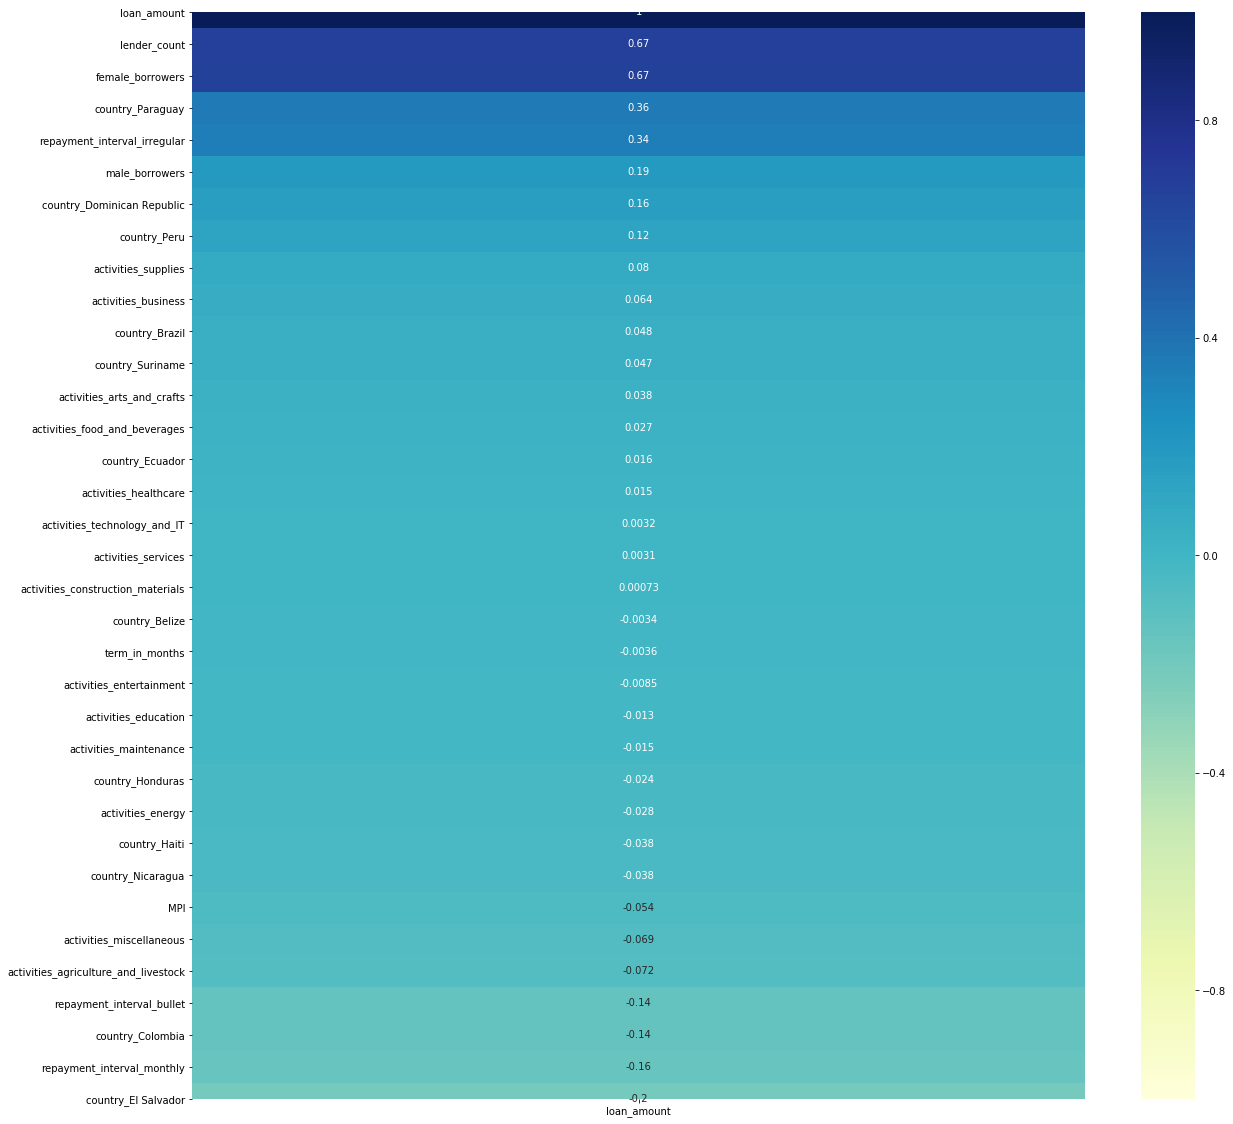

In [ ]:
#creating a correlation plot to see what are the most relevant features
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(df.corr()[[target]].sort_values(target),
vmax=1, vmin=-1, cmap='YlGnBu', annot=True, ax=ax);
ax.invert_yaxis()
plt.show()

## 4.8 Hyperparameter tuning

### 4.8.1 Creating the dictionary of the models

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

models = {'dtr': DecisionTreeRegressor(random_state=42),
          'rfr': RandomForestRegressor(max_depth = 20, random_state=42),
          'mlpr': MLPRegressor(max_iter = 500, early_stopping=True, random_state=42)}

### 4.8.2 Creating the dictionary of pipelines

In [ ]:
from sklearn.pipeline import Pipeline

pipes = {}

for acronym, model in models.items():
    pipes[acronym] = Pipeline([('model', model)])

### 4.8.3 Getting the predefined split cross-validator

In [ ]:
from sklearn.model_selection import PredefinedSplit

# Combine the feature matrix in the training and validation data
X_train_valid = np.vstack((X_train, X_valid))

# Combine the target vector in the training and validation data
y_train_valid = np.append(y_train, y_valid)

# Get the indices of training and validation data
train_valid_idxs = np.append(np.full(X_train.shape[0], -1), np.full(X_valid.shape[0], 0))

# The PredefinedSplit
ps = PredefinedSplit(train_valid_idxs)

### 4.8.4 Creating the dictionary of the parameter grids

In [ ]:
param_grids = {}

#### 4.8.4.1 The parameters for Decision Tree

In [ ]:
# The grids for min_samples_split
min_samples_split_grids = [2, 30, 100]

# The grids for min_samples_leaf
min_samples_leaf_grids = [1, 30, 100]

# The grids for max_depth
max_depth_grids = range(1, 35, 3)

# Update param_grids
param_grids['dtr'] = [{'model__min_samples_split': min_samples_split_grids,
                       'model__min_samples_leaf': min_samples_leaf_grids,
                       'model__max_depth': max_depth_grids}]

#### 4.8.4.2 The parameter grid for Random Forest

In [ ]:
# The grids for min_samples_split
min_samples_split_grids = [2, 20, 100]

# The grids for min_samples_leaf
min_samples_leaf_grids = [1, 20, 100]

# Update param_grids
param_grids['rfr'] = [{'model__min_samples_split': min_samples_split_grids,
                       'model__min_samples_leaf': min_samples_leaf_grids}]

#### 4.8.4.3 The parameter grid for multi-layer perceptron regressor

In [ ]:
# The grids for alpha
alpha_grids = [10 ** i for i in range(-6, -1)]

# The grids for learning_rate_init
learning_rate_init_grids = [10 ** i for i in range(-5, 0)]

# Update param_grids
param_grids['mlpr'] = [{'model__alpha': alpha_grids,
                        'model__learning_rate_init': learning_rate_init_grids}]

### 4.8.5 Creating the directory for the cv regression results

In [ ]:
import os

# Make directory
directory = os.path.dirname('cv_regression_results/')
if not os.path.exists(directory):
    os.makedirs(directory)

### 4.8.6 Hyperparameter Tuning with MSE as accuracy metric

In [ ]:
from sklearn.model_selection import GridSearchCV

# The list of [best_score_, best_params_, best_estimator_] obtained by GridSearchCV
best_score_param_estimator_gs = []

for acronym in pipes.keys():
    # GridSearchCV
    gs = GridSearchCV(estimator=pipes[acronym],
                      param_grid=param_grids[acronym],
                      scoring='neg_mean_squared_error',
                      n_jobs=-1,
                      cv=ps,
                      return_train_score=True)
        
    # Fit the pipeline
    gs = gs.fit(X_train_valid, y_train_valid)
    
    # Update best_score_param_estimator_gs
    best_score_param_estimator_gs.append([gs.best_score_, gs.best_params_, gs.best_estimator_])
    
    # Sort cv_results in ascending order of 'rank_test_score' and 'std_test_score'
    cv_results = pd.DataFrame.from_dict(gs.cv_results_).sort_values(by=['rank_test_score', 'std_test_score'])
    
    # Get the important columns in cv_results
    important_columns = ['rank_test_score',
                         'mean_test_score', 
                         'std_test_score', 
                         'mean_train_score', 
                         'std_train_score',
                         'mean_fit_time', 
                         'std_fit_time',                        
                         'mean_score_time', 
                         'std_score_time']
    
    # Move the important columns ahead
    cv_results = cv_results[important_columns + sorted(list(set(cv_results.columns) - set(important_columns)))]

    # Write cv_results file
    cv_results.to_csv(path_or_buf='cv_regression_results/' + acronym + '.csv', index=False)

KeyboardInterrupt: 

### 4.8.7 Model Selection

In [ ]:
# Sort best_score_param_estimator_gs in descending order of the best_score_
best_score_param_estimator_gs = sorted(best_score_param_estimator_gs, key=lambda x : x[0], reverse=True)

# Print best_score_param_estimator_gs
pd.DataFrame(best_score_param_estimator_gs, columns=['best_score', 'best_param', 'best_estimator'])

## 4.9 Plot the feature importance

In [ ]:
# Get the best_score, best_param and best_estimator of random forest obtained by GridSearchCV
best_score_rfc, best_param_rfc, best_estimator_rfc = best_score_param_estimator_gs[1]

# Get the dataframe of feature and importance
df_fi_rfc = pd.DataFrame(np.hstack((features.reshape(-1, 1), best_estimator_rfc.named_steps['model'].feature_importances_.reshape(-1, 1))),
                         columns=['Features', 'Importance'])

# Sort df_fi_rfc in descending order of the importance
df_fi_rfc = df_fi_rfc.sort_values(ascending=False, by='Importance').reset_index(drop=True)

# Print the first 5 rows of df_fi_rfc
df_fi_rfc.head()

,Features,Importance
0,female_borrowers,0.497261
1,lender_count,0.374262
2,term_in_months,0.0461136
3,male_borrowers,0.0164814
4,activities_food_and_beverages,0.0100161


In [ ]:
# Create the directory for figure_regression

import os

# Make directory
directory = os.path.dirname('./figure_regression/')
if not os.path.exists(directory):
    os.makedirs(directory)

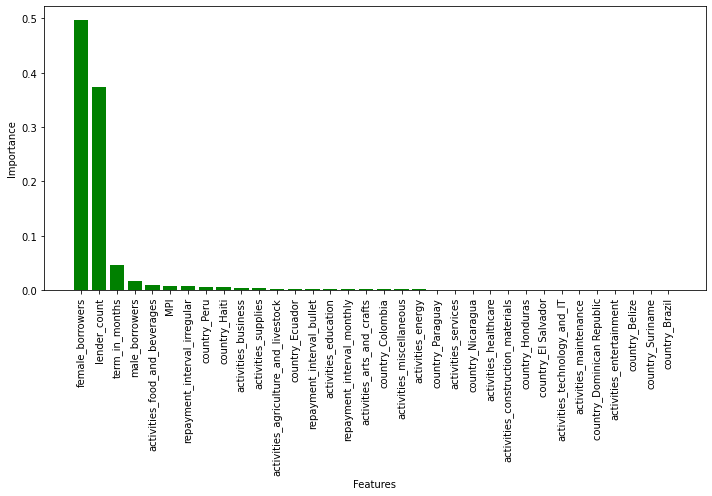

In [ ]:
# Create a figure
fig = plt.figure(figsize=(10, 7))

# The bar plot of feature importance
plt.bar(df_fi_rfc['Features'], df_fi_rfc['Importance'], color='green')

# Set x-axis
plt.xlabel('Features')
plt.xticks(rotation=90)

# Set y-axis
plt.ylabel('Importance')

# Save and show the figure
plt.tight_layout()
plt.savefig('./figure_regression/feature_importance_rfc.pdf')
plt.show()

## 4.10 Generating the submission file

In [ ]:
# Get the best_score, best_param and best_estimator obtained by GridSearchCV
best_score_gs, best_param_gs, best_estimator_gs = best_score_param_estimator_gs[0]

In [ ]:
# Get the prediction on the testing data using best_model
#y_test_pred = best_estimator_gs.predict(X_test)

# Get the dataframe of y_test_pred, which has the same shape as df_train
#df_y_test_pred = pd.DataFrame(np.tile(y_test_pred.reshape(-1, 1), df_train.shape[1]),columns=df_train.columns)

# Transform df_y_test_pred back to the original scale
#df_y_test_pred = pd.DataFrame(ss.inverse_transform(df_y_test_pred),columns=df_train.columns)

# Get the submission dataframe
#df_submit = pd.DataFrame(np.hstack((df_raw_test[['Id']], df_y_test_pred[[target]])),
#                         columns=['Id', target]).astype({'Id':int, target:float})                                                                                       

# Generate the submission file
#df_submit.to_csv('submission_regression.csv', index=False)

ValueError: ignored

In [ ]:
y_test_pred = best_estimator_gs.predict(X_test)
df_submit = pd.DataFrame(y_test_pred,columns=['loan_amount'])
df_submit.to_csv('submission_regression.csv', index=False)

# 5 Classification Analysis

In [ ]:
# Create a copy of df_preprocessed 
df = df_preprocessed.copy(deep=True)

In [ ]:
df.columns

Index(['loan_amount', 'country', 'term_in_months', 'lender_count',
       'repayment_interval', 'MPI', 'activities', 'male_borrowers',
       'female_borrowers'],
      dtype='object')

## 5.1 Define target

In [ ]:
target = 'repayment_interval'

## 5.2 Encoding the features and target

###5.2.1  Encoding the categorical features

In [ ]:
# One-hot-encode the categorical features in the combined data
df = pd.get_dummies(df, columns=np.setdiff1d(np.intersect1d(df.columns, df_cat['var']), [target]))

# Print the first 5 rows of df
df.head()

,loan_amount,term_in_months,lender_count,repayment_interval,MPI,male_borrowers,female_borrowers,activities_agriculture_and_livestock,activities_arts_and_crafts,activities_business,activities_construction_materials,activities_education,activities_energy,activities_entertainment,activities_food_and_beverages,activities_healthcare,activities_maintenance,activities_miscellaneous,activities_services,activities_supplies,activities_technology_and_IT,country_Belize,country_Brazil,country_Colombia,country_Dominican Republic,country_Ecuador,country_El Salvador,country_Haiti,country_Honduras,country_Nicaragua,country_Paraguay,country_Peru,country_Suriname
48,600.0,14.0,16,monthly,0.074,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
49,450.0,14.0,18,monthly,0.032,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
53,550.0,14.0,20,monthly,0.053,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
69,1075.0,17.0,41,monthly,0.053,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
80,1000.0,20.0,34,monthly,0.090,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


### 5.2.2 Encoding the categorical target

In [ ]:
from sklearn.preprocessing import LabelEncoder

# The LabelEncoder
le = LabelEncoder()

# Encode the categorical target in the combined data
df[target] = le.fit_transform(df[target].astype(str))

# Print the first 5 rows of df
df.head()

,loan_amount,term_in_months,lender_count,repayment_interval,MPI,male_borrowers,female_borrowers,activities_agriculture_and_livestock,activities_arts_and_crafts,activities_business,activities_construction_materials,activities_education,activities_energy,activities_entertainment,activities_food_and_beverages,activities_healthcare,activities_maintenance,activities_miscellaneous,activities_services,activities_supplies,activities_technology_and_IT,country_Belize,country_Brazil,country_Colombia,country_Dominican Republic,country_Ecuador,country_El Salvador,country_Haiti,country_Honduras,country_Nicaragua,country_Paraguay,country_Peru,country_Suriname
48,600.0,14.0,16,2,0.074,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
49,450.0,14.0,18,2,0.032,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
53,550.0,14.0,20,2,0.053,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
69,1075.0,17.0,41,2,0.053,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
80,1000.0,20.0,34,2,0.090,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


## 5.3 Creating the train, test and validation dataset

### 5.3.1 Creating a test set

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
#remove target in test set
df_test.drop([target], axis=1, inplace=True)

### 5.3.2 Dividing the training data into training and validation

In [ ]:
from sklearn.model_selection import train_test_split

# Divide: 80% as training set and 20% as validation
df_train, df_valid = train_test_split(df_train, train_size=.8, random_state=42, stratify=df_train[target])

# Reset the index in training and validation sets
df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)

In [ ]:
# Print the dimension of training set
pd.DataFrame([[df_train.shape[0], df_train.shape[1]]], columns=['rows','columns'])

,rows,columns
0,84870,33


In [ ]:
#Print the dimension of validation set
pd.DataFrame([[df_valid.shape[0], df_valid.shape[1]]], columns=['rows','columns'])

,rows,columns
0,21218,33


In [ ]:
# Print the dimension of test set
pd.DataFrame([[df_test.shape[0], df_test.shape[1]]], columns=['rows','columns'])

,rows,columns
0,26523,32


## 5.4 Getting the name of the features

In [ ]:
features = np.setdiff1d(df.columns, [target])

In [ ]:
features

array(['MPI', 'activities_agriculture_and_livestock',
       'activities_arts_and_crafts', 'activities_business',
       'activities_construction_materials', 'activities_education',
       'activities_energy', 'activities_entertainment',
       'activities_food_and_beverages', 'activities_healthcare',
       'activities_maintenance', 'activities_miscellaneous',
       'activities_services', 'activities_supplies',
       'activities_technology_and_IT', 'country_Belize', 'country_Brazil',
       'country_Colombia', 'country_Dominican Republic',
       'country_Ecuador', 'country_El Salvador', 'country_Haiti',
       'country_Honduras', 'country_Nicaragua', 'country_Paraguay',
       'country_Peru', 'country_Suriname', 'female_borrowers',
       'lender_count', 'loan_amount', 'male_borrowers', 'term_in_months'],
      dtype=object)

## 5.5 Getting the feature matrix and target vector

In [ ]:
# Get the feature matrix
X_train = df_train[features].to_numpy()
X_valid = df_valid[features].to_numpy()
X_test = df_test[features].to_numpy()

# Get the target vector
y_train = df_train[target].astype(int).to_numpy()
y_valid = df_valid[target].astype(int).to_numpy()

## 5.6 Scaling the data

In [ ]:
from sklearn.preprocessing import StandardScaler

# The StandardScaler
ss = StandardScaler()

# Standardize the training data
X_train = ss.fit_transform(X_train)

# Standardize the validation data
X_valid = ss.transform(X_valid)

# Standardize the testing data
X_test = ss.transform(X_test)

## 5.7 Correlation Matrix


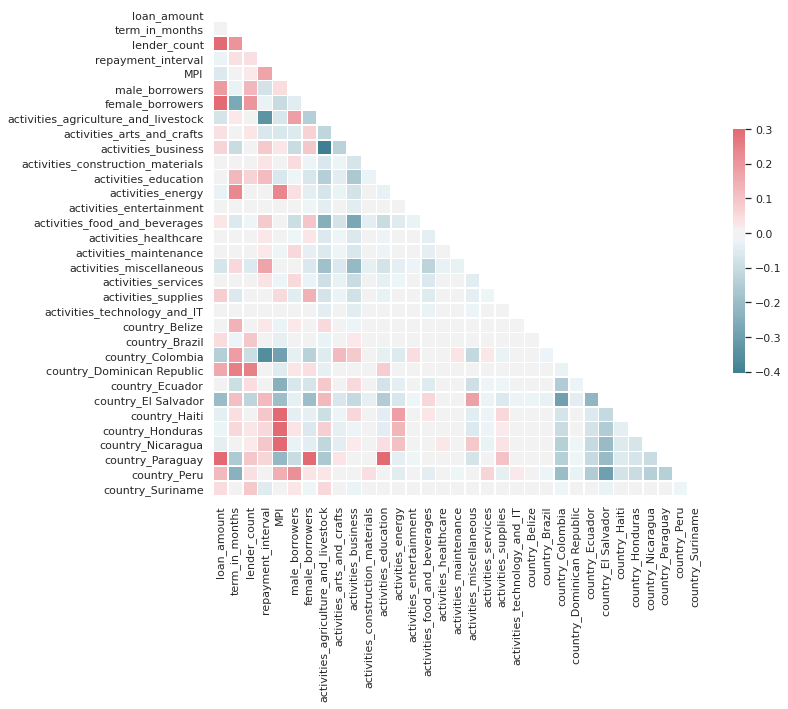

In [ ]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## 5.8 Hyperparameter tuning

### 5.8.1 Creating the dictionary of the models

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.neural_network import MLPClassifier

models = {'lr': LogisticRegression(class_weight='balanced', random_state=42),
          'dtc': DecisionTreeClassifier(class_weight='balanced', random_state=42),
          'rfc': RandomForestClassifier(class_weight='balanced', random_state=42),
          'hgbc': HistGradientBoostingClassifier(random_state=42),
          'xgbc': XGBClassifier(seed=42),
          'mlpc': MLPClassifier(early_stopping=True, random_state=42)}

### 5.8.2 Creating the dictionary of the pipelines

In [ ]:
from sklearn.pipeline import Pipeline

pipes = {}

for acronym, model in models.items():
    pipes[acronym] = Pipeline([('model', model)])

### 5.8.3 Getting the predefined split cross-validator

In [ ]:
from sklearn.model_selection import PredefinedSplit

# Combine the feature matrix in the training and validation data
X_train_valid = np.vstack((X_train, X_valid))

# Combine the target vector in the training and validation data
y_train_valid = np.append(y_train, y_valid)

# Get the indices of training and validation data
train_valid_idxs = np.append(np.full(X_train.shape[0], -1), np.full(X_valid.shape[0], 0))

# The PredefinedSplit
ps = PredefinedSplit(train_valid_idxs)

### 5.8.4 Creating the dictionary of the parameter grids

In [ ]:
param_grids = {}

#### 5.8.4.1 The parameter grid for logistic regression

In [ ]:
# The grids for C
C_grids = [10 ** i for i in range(-2, 3)]

# The grids for tol
tol_grids = [10 ** i for i in range(-6, -1)]

# Update param_grids
param_grids['lr'] = [{'model__C': C_grids,
                      'model__tol': tol_grids}]

#### 5.8.4.2 The parameter grid for decision tree

In [ ]:
# The grids for min_samples_split
min_samples_split_grids = [2, 30, 100]

# The grids for min_samples_leaf
min_samples_leaf_grids = [1, 30, 100]

# The grids for max_depth
max_depth_grids = range(1, 11)

# Update param_grids
param_grids['dtc'] = [{'model__min_samples_split': min_samples_split_grids,
                       'model__min_samples_leaf': min_samples_leaf_grids,
                       'model__max_depth': max_depth_grids}]

#### 5.8.4.3 The parameter grid for random forest

In [ ]:
# The grids for min_samples_split
min_samples_split_grids = [2, 20, 100]

# The grids for min_samples_leaf
min_samples_leaf_grids = [1, 20, 100]

# Implement me
# Update param_grids
param_grids['rfc'] = [{'model__min_samples_split': min_samples_split_grids,
                       'model__min_samples_leaf': min_samples_leaf_grids}]

#### 5.8.4.4 The parameter grid for histogram-based gradient boosting

In [ ]:
# The grids for learning_rate
learning_rate_grids = [10 ** i for i in range(-3, 2)]

# The grids for min_samples_leaf
min_samples_leaf_grids = [1, 20, 100]

# Implement me
# Update param_grids
param_grids['hgbc'] = [{'model__learning_rate': learning_rate_grids,
                        'model__min_samples_leaf': min_samples_leaf_grids}]

#### 5.8.4.5 The parameter grid for xgboost

In [ ]:
# The grids for eta
eta_grids = [10 ** i for i in range(-4, 1)]

# The grids for gamma
gamma_grids = [0, 10, 100]

# The grids for lambda
lambda_grids = [10 ** i for i in range(-4, 5)]

# Implement me
# Update param_grids
param_grids['xgbc'] = [{'model__eta': eta_grids,
                        'model__gamma': gamma_grids,
                        'model__lambda': lambda_grids}]

#### 5.8.4.6 The parameter grid for multi-layer perceptron classifier

In [ ]:
# The grids for alpha
alpha_grids = [10 ** i for i in range(-4, -1)]

# The grids for learning_rate_init
learning_rate_init_grids = [10 ** i for i in range(-4, -1)]

# Update param_grids
param_grids['mlpc'] = [{'model__alpha': alpha_grids,
                        'model__learning_rate_init': learning_rate_init_grids}]

### 5.8.5 Creating the directory for the cv results.

In [ ]:
import os

# Make directory
directory = os.path.dirname('./cv_classification_results/')
if not os.path.exists(directory):
    os.makedirs(directory)

### 5.8.6 Hyperparameter tuning 

In [ ]:
from sklearn.model_selection import GridSearchCV

# The list of [best_score_, best_params_, best_estimator_] obtained by GridSearchCV
best_score_param_estimator_gs = []

for acronym in pipes.keys():
    # GridSearchCV
    gs = GridSearchCV(estimator=pipes[acronym],
                      param_grid=param_grids[acronym],
                      scoring='f1_micro',
                      n_jobs=2,
                      cv=ps,
                      return_train_score=True)
        
    # Fit the pipeline
    gs = gs.fit(X_train_valid, y_train_valid)
    
    # Update best_score_param_estimator_gs
    best_score_param_estimator_gs.append([gs.best_score_, gs.best_params_, gs.best_estimator_])
    
    # Sort cv_results in ascending order of 'rank_test_score' and 'std_test_score'
    cv_results = pd.DataFrame.from_dict(gs.cv_results_).sort_values(by=['rank_test_score', 'std_test_score'])
    
    # Get the important columns in cv_results
    important_columns = ['rank_test_score',
                         'mean_test_score', 
                         'std_test_score', 
                         'mean_train_score', 
                         'std_train_score',
                         'mean_fit_time', 
                         'std_fit_time',                        
                         'mean_score_time', 
                         'std_score_time']
    
    # Move the important columns ahead
    cv_results = cv_results[important_columns + sorted(list(set(cv_results.columns) - set(important_columns)))]

    # Write cv_results file
    cv_results.to_csv(path_or_buf='./cv_classification_results/' + acronym + '.csv', index=False)

### 5.8.7 Model Selection

In [ ]:
# Sort best_score_param_estimator_gs in descending order of the best_score_
best_score_param_estimator_gs = sorted(best_score_param_estimator_gs, key=lambda x : x[0], reverse=True)

# Print best_score_param_estimator_gs
pd.DataFrame(best_score_param_estimator_gs, columns=['best_score', 'best_param', 'best_estimator'])

,best_score,best_param,best_estimator
0,0.874163,"{'model__learning_rate': 0.1, 'model__min_samp...",(HistGradientBoostingClassifier(l2_regularizat...
1,0.856396,"{'model__min_samples_leaf': 1, 'model__min_sam...","((DecisionTreeClassifier(ccp_alpha=0.0, class_..."
2,0.847252,"{'model__alpha': 0.0001, 'model__learning_rate...","(MLPClassifier(activation='relu', alpha=0.0001..."
3,0.844189,"{'model__eta': 0.0001, 'model__gamma': 10, 'mo...","(XGBClassifier(base_score=0.5, booster='gbtree..."
4,0.841361,"{'model__max_depth': 10, 'model__min_samples_l...","(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."
5,0.692997,"{'model__C': 1, 'model__tol': 1e-06}","(LogisticRegression(C=1, class_weight='balance..."


In [ ]:
best_score_gs, best_param_gs, best_estimator_gs = best_score_param_estimator_gs[0]

## 5.9 Confusion Matrix

In [ ]:
# Create the directory for figure_classification
import os

# Make directory
directory = os.path.dirname('./figure_classification/')
if not os.path.exists(directory):
    os.makedirs(directory)

In [ ]:
# Select the best model
classifier = best_estimator_gs

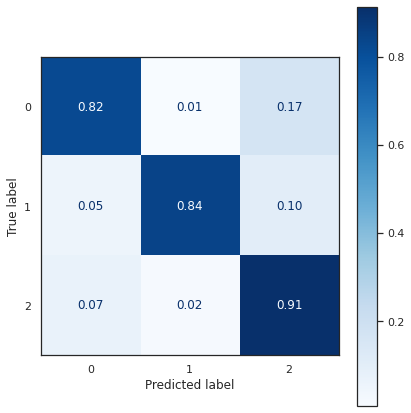

In [ ]:
from sklearn.metrics import plot_confusion_matrix

# Create a figure and axes
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

# Plot the confusion matrix
plot_confusion_matrix(classifier,
                      X_valid,
                      y_valid,
                      normalize='true',
                      display_labels=np.unique(y_valid),
                      values_format='.2f',
                      cmap=plt.cm.Blues,
                      ax=ax)

# Save and show the figure
plt.tight_layout()
plt.savefig('./figure_classification/confusion_matrix.pdf')
plt.show()

## 5.10 Plot the feature importance

In [ ]:
# Get the best_score, best_param and best_estimator of random forest obtained by GridSearchCV
best_score_rfc, best_param_rfc, best_estimator_rfc = best_score_param_estimator_gs[1]

# Get the dataframe of feature and importance
df_fi_rfc = pd.DataFrame(np.hstack((features.reshape(-1, 1), best_estimator_rfc.named_steps['model'].feature_importances_.reshape(-1, 1))),
                         columns=['Features', 'Importance'])

# Sort df_fi_rfc in descending order of the importance
df_fi_rfc = df_fi_rfc.sort_values(ascending=False, by='Importance').reset_index(drop=True)

# Print df_fi_rfc
df_fi_rfc[:10]

,Features,Importance
0,term_in_months,0.317876
1,country_Colombia,0.0986365
2,loan_amount,0.0965385
3,activities_agriculture_and_livestock,0.0956306
4,MPI,0.0824386
5,female_borrowers,0.0578216
6,lender_count,0.0575645
7,country_El Salvador,0.0249598
8,country_Peru,0.0205669
9,activities_business,0.0186295


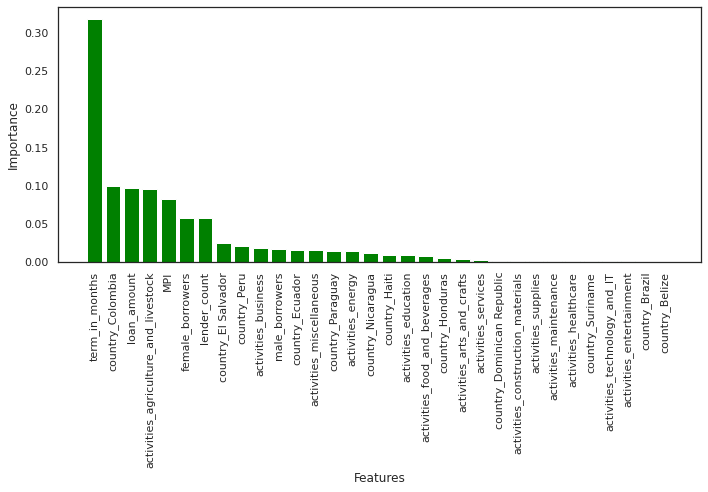

In [ ]:
# Create a figure
fig = plt.figure(figsize=(10, 7))

# The bar plot of feature importance
plt.bar(df_fi_rfc['Features'], df_fi_rfc['Importance'], color='green')

# Set x-axis
plt.xlabel('Features')
plt.xticks(rotation=90)

# Set y-axis
plt.ylabel('Importance')

# Save and show the figure
plt.tight_layout()
plt.savefig('./figure_classification/feature_importance_rfc.pdf')
plt.show()

## 5.11 Generating the submission file

In [ ]:
best_score_gs, best_param_gs, best_estimator_gs = best_score_param_estimator_gs[0]

In [ ]:
# Get the prediction on the testing data using best_model
y_test_pred = best_estimator_gs.predict(X_test)

# Transform y_test_pred back to the original class
y_test_pred = le.inverse_transform(y_test_pred)

# Get the submission dataframe
df_submit = pd.DataFrame(np.hstack((np.arange(1, y_test_pred.shape[0] + 1).reshape(-1, 1), y_test_pred.reshape(-1, 1))),
                         columns=['ImageId', 'Label'])                                                                                      

# Generate the submission file
df_submit.to_csv('submission_classification.csv', index=False)

# 6. Discussion & Conclusion

In predicting Kiva loan amount, our regression models were able to run, yet were not very powerful predictive models based on their accuracy. The negative mean squared error, which would ideally be closer to 0 is quite far off at a level of -160,000 for the MLP regressor. This regressor was the best amongst the other two (Decision Tree and Random Forest). Given that MSE is the summation of the squares of the difference in predicted and actual value divided by the total number of data points, we would like this to be minimized. However, our accuracy in this case was measured by negative MSE, therefore, it should then be maximized. There are likely many reasons why this is a poor model for predicting loan amount, but we speculate that nature of the features we chose are not great indicators of the Latin American Kiva loan amounts under the given parameters. 

Next, in our classification model predicting repayment interval type, our results reveal the best model to be Histogram Gradient Boosting with an F1 score of 0.874. “The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0”. Thus, this is quite a good model based on the F1 score. Additionally, the next best models, Random Forest, and Multilayer Perception Classification both performed well with F1 scores above 0.80. According to our Random Forest Classifier, the top 5 features given in order of importance are: Loan Term (months), Country Colombia, Loan Amount, Agriculture and Livestock Activity, and MPI. Intuitively, due to the nature of money and loans, the Loan Term (0.317876 importance) and Loan Amount (0.0965385) are predictive of the Repayment Interval Type (monthly, bullet, irregular). Interestingly, Colombia has more predictive power than other Latin American countries (imporance of 0.0986365). If we recall some of our EDA plots, Colombia received the 3rd highest number of loans in Latin America and it was highly (negatively) correlated with repayment interval, our target. Agriculture and livestock is the second highest activity in Latin America and is also negatively correlated to repayment interval. MPI being the 5th most important at a value of 0.0824386, indicates that poverty level is playing an important role in Kiva loan activity. 

In all, we were able to achieve our goals of building regression and classification models. However, our regression models predicting loan amount were weak, thus we cannot make conclusions about the features with respect to loan amount. On the other hand, our classification models were quite accurate in predicting repayment interval type. While this may not be the most informative information for Kiva, the model may be useful in determining what a borrowers repayment interval should be, given all other factors. Many future projects could be done using this data, for example, the initial Kaggle competition prompted competitors to predict the level of poverty of each borrower using the original data along with other relevant public datasets. In conclusion, we have accomplished pre-processing and exploratory analysis of this data, and have built classification models to predict repayment interval type of Kiva loans in Latin American countries. 

# 7. Annex: Multitarget classification and prediction

We wanted to try and classify two target variables at the same time, we selected repayment interval and activities as the target since they both contain multiple classes.

In [ ]:
# Create a copy of df_preprocessed 
df_wod = df_preprocessed.copy(deep=True)

In [ ]:
df_wod.columns

Index(['loan_amount', 'country', 'term_in_months', 'lender_count',
       'repayment_interval', 'MPI', 'activities', 'male_borrowers',
       'female_borrowers'],
      dtype='object')

## 7.1 Define target

In [ ]:
target = ['repayment_interval','activities']

## 7.2 Encoding the features and target

In [ ]:
# Enconding the categorical features
df = pd.get_dummies(df_wod, columns=np.setdiff1d(np.intersect1d(df_wod.columns, df_cat['var']), [target]))

# Print the first 5 rows of df
df.head()

,loan_amount,term_in_months,lender_count,repayment_interval,MPI,activities,male_borrowers,female_borrowers,country_Belize,country_Brazil,country_Colombia,country_Dominican Republic,country_Ecuador,country_El Salvador,country_Haiti,country_Honduras,country_Nicaragua,country_Paraguay,country_Peru,country_Suriname
48,600.0,14.0,16,monthly,0.074,business,0,1,0,0,0,0,0,0,0,0,1,0,0,0
49,450.0,14.0,18,monthly,0.032,business,1,0,0,0,0,0,0,1,0,0,0,0,0,0
53,550.0,14.0,20,monthly,0.053,miscellaneous,1,0,0,0,0,0,0,0,0,0,0,0,1,0
69,1075.0,17.0,41,monthly,0.053,services,1,0,0,0,0,0,0,0,0,0,0,0,1,0
80,1000.0,20.0,34,monthly,0.090,business,0,1,0,0,0,0,0,0,0,1,0,0,0,0


#### We custom encoded the target variables:

In [ ]:
# Setting mutliple targets and label encoding for targets
tt=df[target]

map_rep_interval = {'monthly':0, 
                  'irregular':1, 
                  'bullet':2 }

map_activities = {'business': 0,
                 'miscellaneous': 1 ,
                 'services': 2 ,
                   'education': 3 ,
                   'construction_materials': 4 ,
                   'arts_and_crafts': 5 ,
                    'energy': 6 ,
                   'food_and_beverages': 7 ,
                   'agriculture_and_livestock': 8 ,
                    None: 9 ,
                   'maintenance': 10 ,
                   'entertainment': 11 ,
                   'supplies': 12 ,
                   'healthcare':13 ,
                   'technology_and_IT': 14 }

In [ ]:
## setting encoded values for repayment interval
encoded_interval=[]
for rep in tt['repayment_interval']:
    for key, value in map_rep_interval.items():
        if key ==rep:
            encoded_interval.append(value)

In [ ]:
# setting encoded values for activities
encoded=[]
for act in tt['activities']:
    for key, value in map_activities.items():
        if key ==act:
            encoded.append(value)

In [ ]:
tt['repayment_interval']=encoded_interval

In [ ]:
tt['activities']=encoded

In [ ]:
# Dropping values for dataset
d1=df.drop('repayment_interval',axis=1)
final_data=d1.drop('activities',axis=1)

## 7.3 Fitting data for multi target predictions

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(final_data, tt)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
rf = RandomForestClassifier(max_depth=2, random_state=0)
rf.fit(final_data, tt)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

## 7.4 Prediction with user input

In [ ]:
loan_amount=input("Enter the loan amount: ")
term_in_months=input("Enter term in months: ")
lender_count=input("Enter the number of lenders: ")
male_borrowers=input("Enter the number of male borrowers: ")
female_borrowers=input("Enter the number of female borrowers: ")
country=input("Enter the the name of the country: ")

Enter the loan amount: 100
Enter term in months: 15
Enter the number of lenders: 7
Enter the number of male borrowers: 5
Enter the number of female borrowers: 0
Enter the the name of the country: Belize


In [ ]:
#mapping the user input of country to the appropriate MPI
user_in=['country','MPI']
user_input=df_wod[user_in]
mpi_c_list=[]
mpi_mp_list=[]
for c,mp in zip(user_input['country'],user_input['MPI']):
    if c not in mpi_c_list:
        mpi_c_list.append(c)
        mpi_mp_list.append(mp) 

In [ ]:
mpi = pd.DataFrame()
mpi['mpi_c_list']=mpi_c_list
mpi['mpi_mp_list']=mpi_mp_list

In [ ]:
# since the country variable has been one hot encoded, we generate a vector based on the country to append to the input of the predict function
def checkcountry(country):    
    if country=="Nicaragua":
        v1=0,0,0,0,0,0,0,0,1,0,0,0
    elif country=="El Salvador":
        v1=0,0,0,0,0,1,0,0,0,0,0,0
    elif country=="Peru":
        v1=0,0,0,0,0,0,0,0,0,0,1,0
    elif country=="Honduras":
        v1=0,0,0,0,0,0,0,1,0,0,0,0
    elif country=="Colombia":
        v1=0,0,1,0,0,0,0,0,0,0,0,0
    elif country=="Ecuador":
        v1=0,0,0,0,1,0,0,0,0,0,0,0
    elif country=="Haiti":
        v1=0,0,0,0,0,0,1,0,0,0,0,0
    elif country=="Dominican Republic":
        v1=0,0,0,1,0,0,0,0,0,0,0,0
    elif country=="Dominican Republic":
        v1=0,0,0,1,0,0,0,0,0,0,0,0
    elif country=="Brazil":
        v1=0,1,0,0,0,0,0,0,0,0,0,0
    elif country=="Paraguay":
        v1=0,0,0,0,0,0,0,0,0,1,0,0
    elif country=="Belize":
        v1=1,0,0,0,0,0,0,0,0,0,0,0
    elif country=="Suriname":
        v1=0,0,0,0,0,0,0,0,0,0,0,1
    return list(v1)

In [ ]:
val=checkcountry(country)
co=mpi['mpi_c_list']
mp=mpi['mpi_mp_list']
for i in range (0,len(co)):
    if country==co[i]:
        mpi_val=mp[i]

In [ ]:
#preparing the input array
input_test_1=[]
input_test_1.append(int(loan_amount))
input_test_1.append(int(term_in_months))
input_test_1.append(int(lender_count))
input_test_1.append(int(male_borrowers))
input_test_1.append(int(female_borrowers))
input_test_1.append(mpi_val)
for v in val:
    input_test_1.append(v)

## 7.5 Output

In [ ]:
#KNN-prediction function
val1=(neigh.predict([input_test_1]))

output=[]
for v in val1:
    for vv in v:
        output.append(vv)

for k,v in map_rep_interval.items():
    if v==output[0]:
        print("Repayment Interval Prediction:",k)

for k,v in map_activities.items():
    if v==output[1]:
        print("Activities Prediction:",k)

Repayment Interval Prediction: monthly
Activities Prediction: agriculture_and_livestock


In [ ]:
#random-forest-prediction function
val2=rf.predict([input_test_1])

output_rf=[]
for v in val1:
    for vv in v:
        output_rf.append(vv)

for k,v in map_rep_interval.items():
    if v==output[0]:
        print("Repayment Interval Prediction:",k)

for k,v in map_activities.items():
    if v==output[1]:
        print("Activities Prediction:",k)

Repayment Interval Prediction: monthly
Activities Prediction: agriculture_and_livestock


## 7.6 Discussion

In this section, we have built models to predict both repayment interval and loan activity as multi-targets. First, we encoded both target variables. Next, we fit the data for KNN and RF classifiers. This allowed us to use user input for each of the other variables and predict the repayment interval and activity of that loan. This was an experimental section, and we do not have accuracy measures to make conclusions, however, it is quite interesting to play around with. This could be a useful tool to Kiva borrowers and lenders in determining the repayment interval or activity of missing data or future loans.